
Best Hyperparameters: {'classifier__max_depth': 20, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}

Confusion Matrix:
[[ 991  251]
 [ 143 1965]]

Classification Report:
              precision    recall  f1-score   support

       False       0.87      0.80      0.83      1242
        True       0.89      0.93      0.91      2108

    accuracy                           0.88      3350
   macro avg       0.88      0.87      0.87      3350
weighted avg       0.88      0.88      0.88      3350



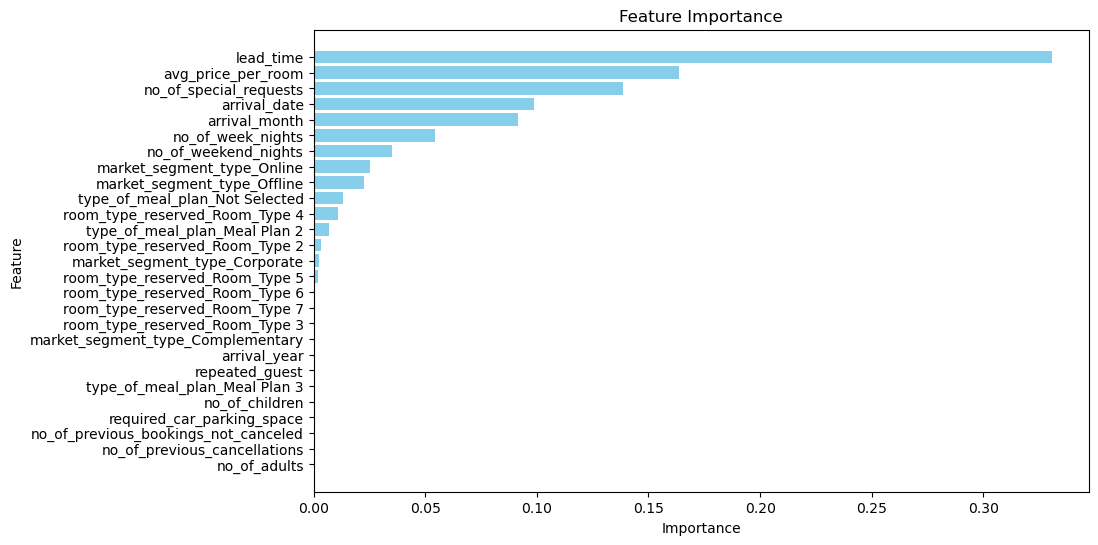


Feature Importance:
                                 Feature  Importance
5                              lead_time    0.330528
12                    avg_price_per_room    0.163714
13                no_of_special_requests    0.138380
8                           arrival_date    0.098879
7                          arrival_month    0.091547
3                      no_of_week_nights    0.054570
2                   no_of_weekend_nights    0.035252
26            market_segment_type_Online    0.025191
25           market_segment_type_Offline    0.022665
16        type_of_meal_plan_Not Selected    0.013107
19        room_type_reserved_Room_Type 4    0.011037
14         type_of_meal_plan_Meal Plan 2    0.006806
17        room_type_reserved_Room_Type 2    0.003248
24         market_segment_type_Corporate    0.002363
20        room_type_reserved_Room_Type 5    0.002117
21        room_type_reserved_Room_Type 6    0.000340
22        room_type_reserved_Room_Type 7    0.000126
18        room_type_reser

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import pickle
import warnings

# Filter out any warnings
warnings.filterwarnings("ignore")

# Step 1: Read the cleaned dataset
df_cleaned = pd.read_csv('cleaned_dataset1.csv')

# Step 1.1: Drop non-numeric columns
df_cleaned.drop(columns=['Booking_ID'], inplace=True)

# Step 2: Split the dataset into features (X) and target variable (y)
X = df_cleaned.drop(columns=['booking_status_Not_Canceled'])
y = df_cleaned['booking_status_Not_Canceled']

# Step 3: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Define preprocessing steps
numeric_features = X.columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

# Step 5: Define the model
rf_classifier = RandomForestClassifier()

# Step 6: Create the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', rf_classifier)])

# Step 7: Define the hyperparameters grid
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['auto', 'sqrt', 'log2']
}

# Step 8: Initialize Grid Search with cross-validation
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy')

# Step 9: Fit the Grid Search to the training data
grid_search.fit(X_train, y_train)

# Step 10: Get the best hyperparameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Step 11: Make predictions on the testing data using the best model
y_pred_best = best_model.predict(X_test)

# Step 12: Evaluate the best model
print("\nBest Hyperparameters:", best_params)
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_best))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))

# Step 13: Obtain feature importances
feature_importances = best_model.named_steps['classifier'].feature_importances_

# Step 14: Create a DataFrame to hold feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Step 15: Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Step 16: Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to show most important features on top
plt.show()

# Step 17: Display the feature importance DataFrame
print("\nFeature Importance:")
print(feature_importance_df)

# Step 18: Pickle the Random Forest model for deployment
with open('random_forest_best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)